# XMM-LSS master catalogue
## Preparation of Spitzer datafusion SERVS data

The Spitzer catalogues were produced by the datafusion team are available in `dmu0_DataFusion-Spitzer`.
Lucia told that the magnitudes are aperture corrected.

In the catalouge, we keep:

- The internal identifier (this one is only in HeDaM data);
- The position;
- The fluxes in aperture 2 (1.9 arcsec);
- The “auto” flux (which seems to be the Kron flux);
- The stellarity in each band

A query of the position in the Spitzer heritage archive show that the SERVS-ELAIS-N1 images were observed in 2009. Let's take this as epoch.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
91cdb7b (Fri Oct 20 11:48:11 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "servs_ra"
DEC_COL = "servs_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'internal_id': "servs_intid",
        'ra_12': "servs_ra",
        'dec_12': "servs_dec",
        'flux_aper_2_1': "f_ap_servs_irac_i1",
        'fluxerr_aper_2_1': "ferr_ap_servs_irac_i1",
        'flux_auto_1': "f_servs_irac_i1",
        'fluxerr_auto_1': "ferr_servs_irac_i1",
        'class_star_1': "servs_stellarity_irac_i1",
        'flux_aper_2_2': "f_ap_servs_irac_i2",
        'fluxerr_aper_2_2': "ferr_ap_servs_irac_i2",
        'flux_auto_2': "f_servs_irac_i2",
        'fluxerr_auto_2': "ferr_servs_irac_i2",
        'class_star_2': "servs_stellarity_irac_i2",
    })


catalogue = Table.read("../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SERVS_XMM-LSS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2009

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding magnitude and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        magnitude, error = flux_to_mag(
            np.array(catalogue[col])/1.e6, np.array(catalogue[errcol])/1.e6)
        # Note that some fluxes are 0.
        
        catalogue.add_column(Column(magnitude, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))


/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [6]:
catalogue[:10].show_in_notebook()

idx,servs_intid,servs_ra,servs_dec,f_ap_servs_irac_i1,ferr_ap_servs_irac_i1,f_servs_irac_i1,ferr_servs_irac_i1,servs_stellarity_irac_i1,f_ap_servs_irac_i2,ferr_ap_servs_irac_i2,f_servs_irac_i2,ferr_servs_irac_i2,servs_stellarity_irac_i2,m_ap_servs_irac_i1,merr_ap_servs_irac_i1,m_servs_irac_i1,merr_servs_irac_i1,flag_servs_irac_i1,m_ap_servs_irac_i2,merr_ap_servs_irac_i2,m_servs_irac_i2,merr_servs_irac_i2,flag_servs_irac_i2
,,deg,deg,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,,,,,,,,,,
0,3144961,36.38934865,-4.54067595,2.72794513683,0.39679731827,2.83978802269,0.395099641282,0.53,3.97903183781,0.331929236014,3.14651241546,0.310649966003,0.78,22.8104109206,0.157927374924,22.7667851921,0.151058452814,False,22.4005564647,0.0905716776462,22.6554263757,0.107192939535,False
1,3144860,36.39202055,-4.53964515,10.1303417122,0.382968258195,9.26262693275,0.473620181909,0.98,7.67742287585,0.344991095247,6.56763773516,0.382164676704,0.96,21.3859397624,0.0410452593811,21.4831645688,0.0555162787551,False,21.686961344,0.0487884187814,21.8564770263,0.0631779708945,False
2,3610774,36.4028804,-4.5404845,nan,nan,nan,nan,nan,0.865724332876,0.366036582042,0.818237638522,0.396663836871,0.36,nan,nan,nan,nan,False,24.056550939,0.45905971947,24.1178013676,0.526341332313,False
3,3143849,36.40189865,-4.54011655,5.78424966637,0.412670950062,6.17518609526,0.588210547261,0.13,3.82852811878,0.364401572218,4.31409691856,0.496570187927,0.4,21.9943824245,0.0774606590272,21.923374875,0.103420605846,False,22.4424203972,0.10334101455,22.3127752561,0.124972674795,False
4,3143362,36.4026693,-4.5392439,1.24166722837,0.375581479092,2.18812539263,0.644955870809,0.09,nan,nan,nan,nan,nan,23.6649869529,0.328415214939,23.0498194849,0.320023679524,False,nan,nan,nan,nan,False
5,3142687,36.40593275,-4.5401428,1.48745412472,0.372374791613,1.09034262863,0.344591993009,0.07,0.9603132004,0.394307345245,0.684499010191,0.371849084082,0.39,23.4688910492,0.27180723511,23.8060925204,0.34313617835,False,23.9439677533,0.445806389369,24.3115679388,0.589818257271,False
6,3143271,36.40709865,-4.5404349,4.4409589984,0.40317708705,4.86063793188,0.671425559914,0.35,5.49277527802,0.420510329743,5.53048349775,0.511386326099,0.65,22.2813080912,0.0985696919285,22.1832668206,0.149978469784,False,22.0505204215,0.0831206933413,22.043092248,0.10039459463,False
7,3143011,36.4079405,-4.5398046,1.306771562,0.37373971949,1.59388144302,0.56066189583,0.01,nan,nan,nan,nan,nan,23.6095008131,0.310523090956,23.3938599642,0.38191731361,False,nan,nan,nan,nan,False
8,3143071,36.40973895,-4.5403673,2.57484079146,0.390316495946,3.92363491067,0.762240009689,0.18,1.45463700692,0.434967744393,0.994184319451,0.280236680248,0.52,22.8731240481,0.164585224985,22.4157785249,0.210924714984,False,23.4931134197,0.324658472005,23.9063327274,0.306042957723,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['ferr_ap_servs_irac_i1', 'ferr_ap_servs_irac_i2']
FLAG_NAME = "servs_flag_cleaned"

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 2366 sources.
The cleaned catalogue has 2366 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_XMM-LSS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

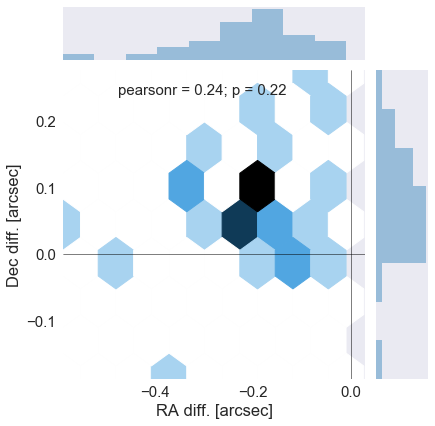

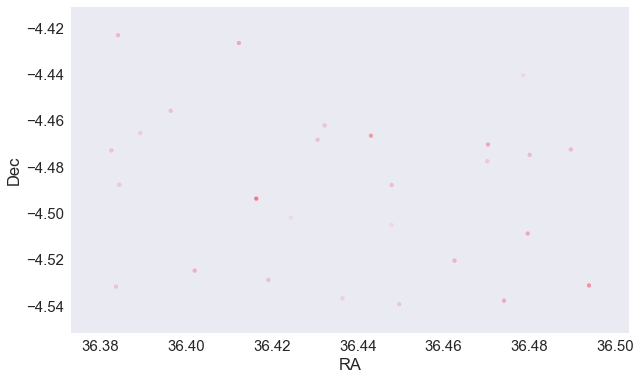

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.18299317860055453 arcsec
Dec correction: -0.07783612333227552 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

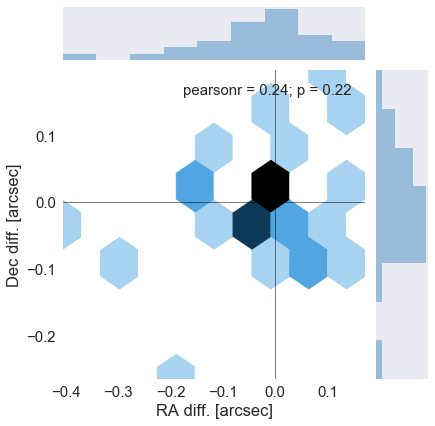

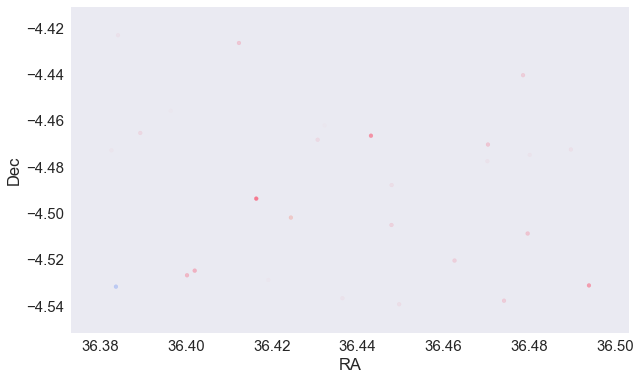

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "servs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

29 sources flagged.


## V - Saving to disk

In [16]:
catalogue.write("{}/SERVS.fits".format(OUT_DIR), overwrite=True)